In [5]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [6]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


In [7]:
SEED = 1000
IMG_SIZE = 224
BATCH_SIZE = 64

TRAIN_DIR = '../input/bird-species-classification-220-categories/Train'

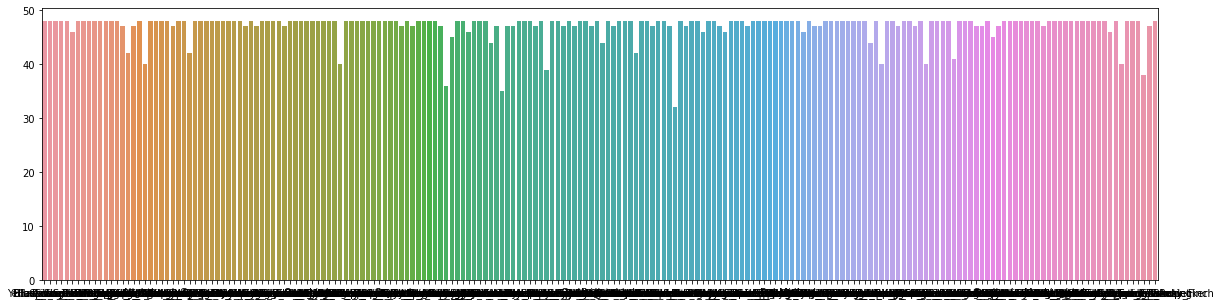

In [8]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
  files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
  class_names.append(f)
  class_count.append(len(files))
  train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.show()

In [9]:
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

In [10]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode = 'categorical',
    seed=SEED
)

Found 6662 images belonging to 200 classes.


In [11]:
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode = 'categorical',
    seed=SEED
)

Found 2752 images belonging to 200 classes.


In [12]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

234561536/234545216 [==============================] - 1s 0us/step


In [13]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [14]:
base_model.trainable = False

In [15]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.4)(x)


outputs = tf.keras.layers.Dense(200, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              419635

In [17]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-4, momentum=0.9),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#     loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
h = model.fit(train_batch, 
              epochs=100,
              steps_per_epoch = 6662 // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = 2752 // BATCH_SIZE,
              callbacks=[cb, reduce_lr]
             )

Epoch 1/100
104/104 [==============================] - 194s 2s/step - loss: 3.4090 - accuracy: 0.2527 - val_loss: 2.7489 - val_accuracy: 0.3368
Epoch 2/100
104/104 [==============================] - 149s 1s/step - loss: 2.0598 - accuracy: 0.4794 - val_loss: 2.2228 - val_accuracy: 0.4281
Epoch 3/100
104/104 [==============================] - 151s 1s/step - loss: 1.5886 - accuracy: 0.5781 - val_loss: 2.1206 - val_accuracy: 0.4531
Epoch 4/100
104/104 [==============================] - 149s 1s/step - loss: 1.3183 - accuracy: 0.6381 - val_loss: 1.9761 - val_accuracy: 0.4855
Epoch 5/100
104/104 [==============================] - 151s 1s/step - loss: 1.1203 - accuracy: 0.6907 - val_loss: 2.1625 - val_accuracy: 0.4604
Epoch 6/100
104/104 [==============================] - 150s 1s/step - loss: 0.9624 - accuracy: 0.7279 - val_loss: 2.1348 - val_accuracy: 0.4789

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 7/100
104/104 [==============================] -

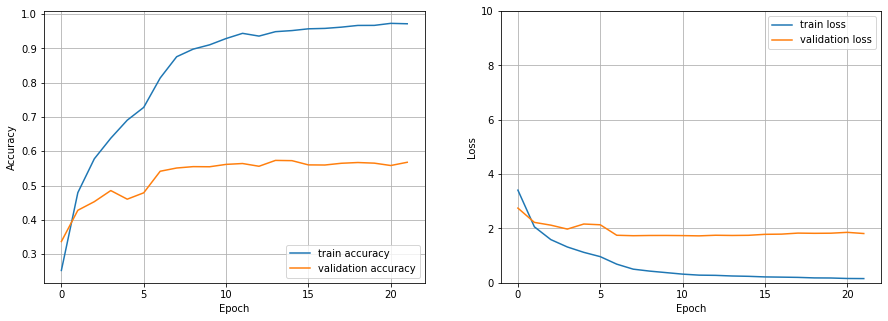

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],  label='train accuracy')
plt.plot(h.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'],  label='train loss')
plt.plot(h.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,10])
plt.legend(loc='upper right')
plt.savefig ("VGGNet16_RMSprop.pdf",dpi=300)
plt.show()